Setup and Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Eyes.zip

Archive:  /content/gdrive/MyDrive/Eyes.zip
   creating: Eyes/
   creating: Eyes/test/
   creating: Eyes/test/cataract/
 extracting: Eyes/test/cataract/cataract-100.jpg  
 extracting: Eyes/test/cataract/cataract-101.jpg  
  inflating: Eyes/test/cataract/cataract-103.jpg  
 extracting: Eyes/test/cataract/cataract-110.jpg  
  inflating: Eyes/test/cataract/cataract-117.jpg  
 extracting: Eyes/test/cataract/cataract-121.jpg  
  inflating: Eyes/test/cataract/cataract-122.jpg  
 extracting: Eyes/test/cataract/cataract-13.jpg  
 extracting: Eyes/test/cataract/cataract-135.jpg  
  inflating: Eyes/test/cataract/cataract-143.jpg  
 extracting: Eyes/test/cataract/cataract-168.jpg  
 extracting: Eyes/test/cataract/cataract-179.jpg  
  inflating: Eyes/test/cataract/cataract-190.jpg  
  inflating: Eyes/test/cataract/cataract-2.jpg  
 extracting: Eyes/test/cataract/cataract-201.jpg  
 extracting: Eyes/test/cataract/cataract-224.jpg  
 extracting: Eyes/test/cataract/cataract-235.jpg  
 extracting: Eyes

Importing Neccessary Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

Data Processing

In [ ]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Model Construction

In [ ]:
class_names = ["cataract", "healthy"]

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add custom head to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the ResNet-based model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 3s 0us/step


Compile the Model

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Train the Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
40/40 [==============================] - 30s 457ms/step - loss: 0.1072 - accuracy: 0.9648 - val_loss: 0.1014 - val_accuracy: 0.9648
Epoch 2/10
40/40 [==============================] - 18s 421ms/step - loss: 0.0428 - accuracy: 0.9849 - val_loss: 0.0739 - val_accuracy: 0.9868
Epoch 3/10
40/40 [==============================] - 22s 523ms/step - loss: 0.0631 - accuracy: 0.9786 - val_loss: 0.0265 - val_accuracy: 0.9912
Epoch 4/10
40/40 [==============================] - 19s 417ms/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.0707 - val_accuracy: 0.9868
Epoch 5/10
40/40 [==============================] - 20s 471ms/step - loss: 0.0272 - accuracy: 0.9950 - val_loss: 0.0681 - val_accuracy: 0.9824
Epoch 6/10
40/40 [==============================] - 20s 436ms/step - loss: 0.0811 - accuracy: 0.9686 - val_loss: 0.0500 - val_accuracy: 0.9824
Epoch 7/10
40/40 [==============================] - 18s 415ms/step - loss: 0.1275 - accuracy: 0.9648 - val_loss: 0.0655 - val_accuracy: 0.9824

Plot Epoch VS Training and Validation Accuracy

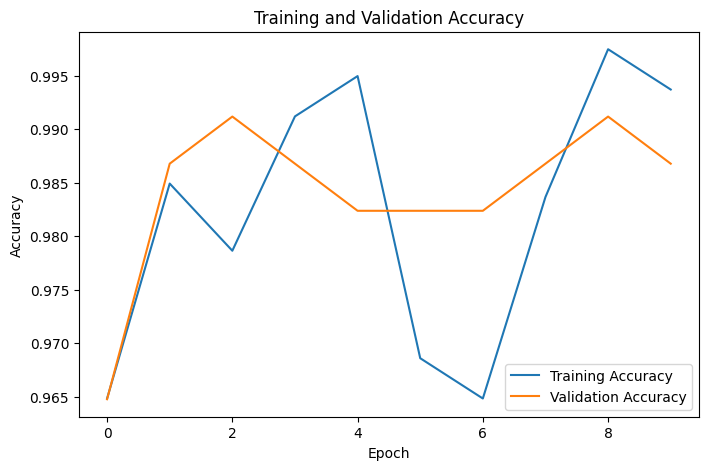

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(10)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Evaluate Model

In [ ]:
model.evaluate(test_ds)

12/12 [==============================] - 5s 144ms/step - loss: 0.0628 - accuracy: 0.9865


[0.06276479363441467, 0.9865471124649048]

Visualization of some Prediction

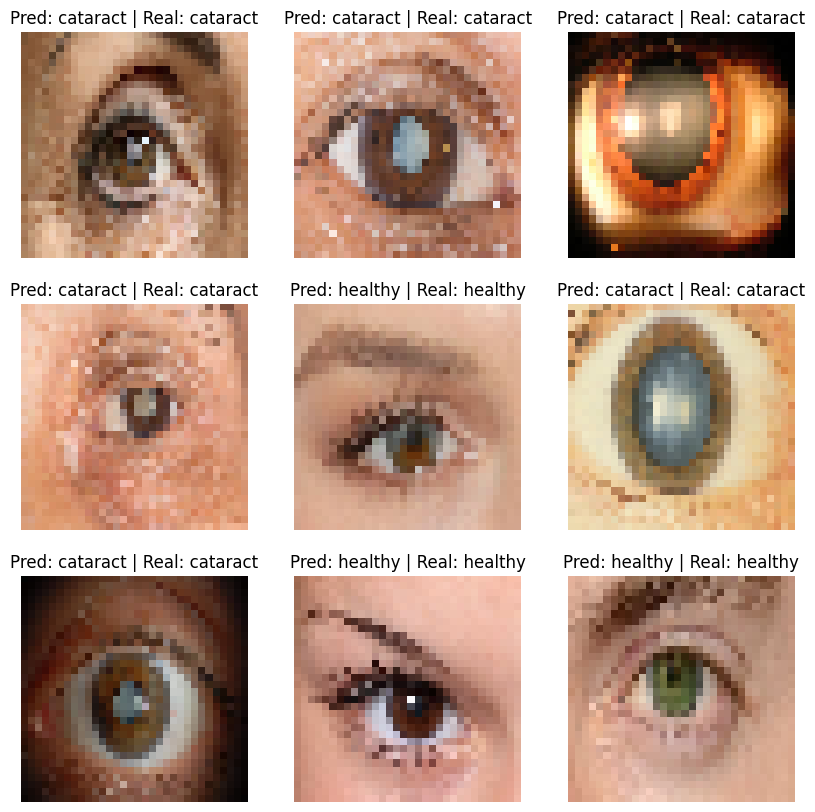

In [ ]:
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = tf.argmax(classifications[i]).numpy()
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])
        plt.axis("off")

Tflite model conversion

In [ ]:
import os
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Evaluate the model to get its accuracy
accuracy = model.evaluate(test_ds)[1]  # Assuming the accuracy is the second value returned by evaluate

# Name the TensorFlow Lite file with accuracy
filename = f"model_accuracy_ResNet50_{accuracy:.4f}.tflite"  # Using 4 decimal places for accuracy
file_path = os.path.join("models", filename)  # Adjust the path as needed

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the TensorFlow Lite model to file
with open(file_path, 'wb') as f:
    f.write(tflite_model)

12/12 [==============================] - 4s 140ms/step - loss: 0.0628 - accuracy: 0.9865


Average Execution Time

In [ ]:
import time
# Define a function to measure the execution time of a single run
def measure_execution_time(model, input_data):
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time
# Run multiple iterations and measure the execution time for each iteration
num_iterations = 5 
total_execution_time = 0

for _ in range(num_iterations):
    execution_time = measure_execution_time(model, test_ds)
    total_execution_time += execution_time

average_execution_time = total_execution_time / num_iterations

print("Average Execution Time:", average_execution_time)

12/12 [==============================] - 5s 220ms/step
Average Execution Time: 5.443800210952759


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

Plot precision, recall, and F1 score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict classes for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 0s 51ms/step
Precision: 0.9865867629320544
Recall: 0.9865470852017937
F1 Score: 0.9865470852017937


Plot confusion matrix

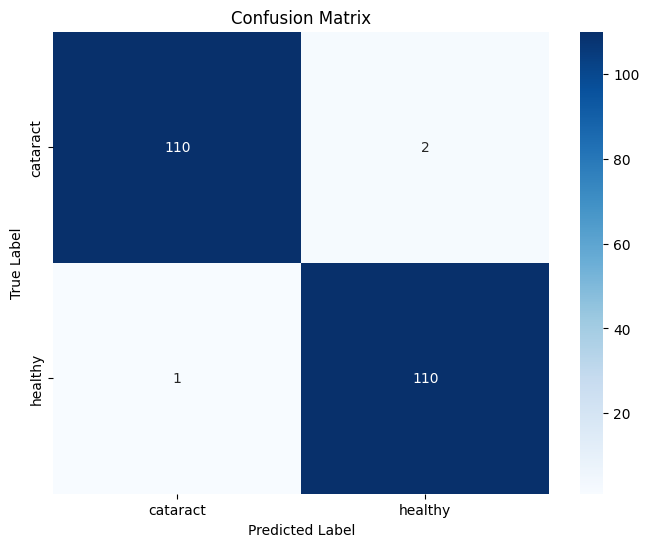

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 50ms/step


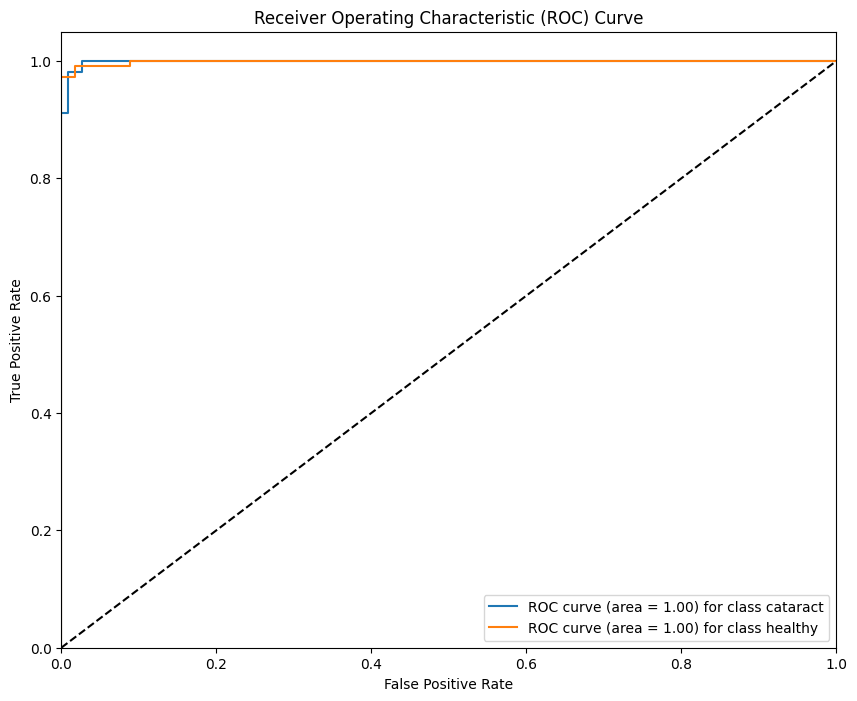

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels to one-hot encoding
y_true = to_categorical(y_true, num_classes=len(class_names))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()